In [35]:
import os
import json
import math
import random
import pickle
import warnings
import h5py
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model, load_model
from tqdm import tqdm_notebook
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras import backend as K
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime
tbc=TensorBoardColab()

warnings.filterwarnings('ignore')
tf.random.set_seed(41)
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
image_file = '/content/drive/My Drive/datasets/train_images.h5py'
mask_file = '/content/drive/My Drive/datasets/target_images.h5py'
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [ ]:
hfile1 = h5py.File(image_file, 'r')
n1 = hfile1.get('all_train_images')
images = np.array(n1)
hfile1.close()
hfile2 = h5py.File(mask_file, 'r')
n2 = hfile2.get('all_target_images')
masks = np.array(n2)
hfile2.close()
masks = np.expand_dims(masks, -1)

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=41)

In [40]:
def build_unet(input_shape=(256, 256, 3), dropout_rates=(0.1, 0.2, 0.3)):
    inputs = Input(input_shape)
    s = Lambda(lambda x: x / 255.0)(inputs)

    def conv_block(x, filters, dropout_rate):
        x = Conv2D(filters, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    def upsample_block(x, skip_connection, filters, dropout_rate):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip_connection])
        x = conv_block(x, filters, dropout_rate)
        return x

    conv1 = conv_block(s, 16, dropout_rates[0])
    pooling1 = MaxPooling2D((2, 2))(conv1)

    conv2 = conv_block(pooling1, 32, dropout_rates[0])
    pooling2 = MaxPooling2D((2, 2))(conv2)

    conv3 = conv_block(pooling2, 64, dropout_rates[1])
    pooling3 = MaxPooling2D((2, 2))(conv3)

    conv4 = conv_block(pooling3, 128, dropout_rates[1])
    pooling4 = MaxPooling2D((2, 2))(conv4)

    conv5 = conv_block(pooling4, 256, dropout_rates[2])

    upsample6 = upsample_block(conv5, conv4, 128, dropout_rates[1])
    upsample7 = upsample_block(upsample6, conv3, 64, dropout_rates[1])
    upsample8 = upsample_block(upsample7, conv2, 32, dropout_rates[0])
    upsample9 = upsample_block(upsample8, conv1, 16, dropout_rates[0])

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(upsample9)

    model = Model(inputs, outputs, name="U-Net")
    return model

model = build_unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [0]:
model_path = "/content/drive/My Drive/datasets/road_mapper.h5"

checkpointer = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopper = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, verbose=1, epsilon=1e-4)

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=opt, loss=soft_dice_loss, metrics=[iou_coef])

In [46]:
history = model.fit(train_images, train_masks / 255, validation_split=0.1, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, callbacks=[checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)])

Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 13s 18ms/step - loss: 0.8820 - iou_coef: 0.0587 - val_loss: 0.8323 - val_iou_coef: 0.0746

Epoch 00001: val_loss improved from inf to 0.83233, saving model to /content/drive/My Drive/datasets/road_mapper.h5
Epoch 2/100
720/720 [==============================] - 10s 14ms/step - loss: 0.8512 - iou_coef: 0.0715 - val_loss: 0.8226 - val_iou_coef: 0.0824

Epoch 00002: val_loss improved from 0.83233 to 0.82264, saving model to /content/drive/My Drive/datasets/road_mapper.h5
Epoch 3/100
720/720 [==============================] - 10s 14ms/step - loss: 0.8375 - iou_coef: 0.0772 - val_loss: 0.8088 - val_iou_coef: 0.0892

Epoch 00003: val_loss improved from 0.82264 to 0.80884, saving model to /content/drive/My Drive/datasets/road_mapper.h5
Epoch 4/100
720/720 [==============================] - 10s 14ms/step - loss: 0.8269 - iou_coef: 0.0827 - val_loss: 0.8060 - val_iou_coef: 0.0921

Epoch 00004: va

In [0]:
model.save("/content/drive/My Drive/datasets/road_mapper_final.h5")

In [0]:
model = load_model("/content/drive/My Drive/datasets/road_mapper_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [49]:
model.evaluate(test_images, test_masks)

200/200 [==============================] - 2s 11ms/step


[-0.18390475749969482, 2.150346250534058]

In [50]:
predictions = model.predict(test_images, verbose=1)


200/200 [==============================] - 2s 11ms/step


In [0]:
predicton_threshold = (predictions > 0.1).astype(np.uint8)

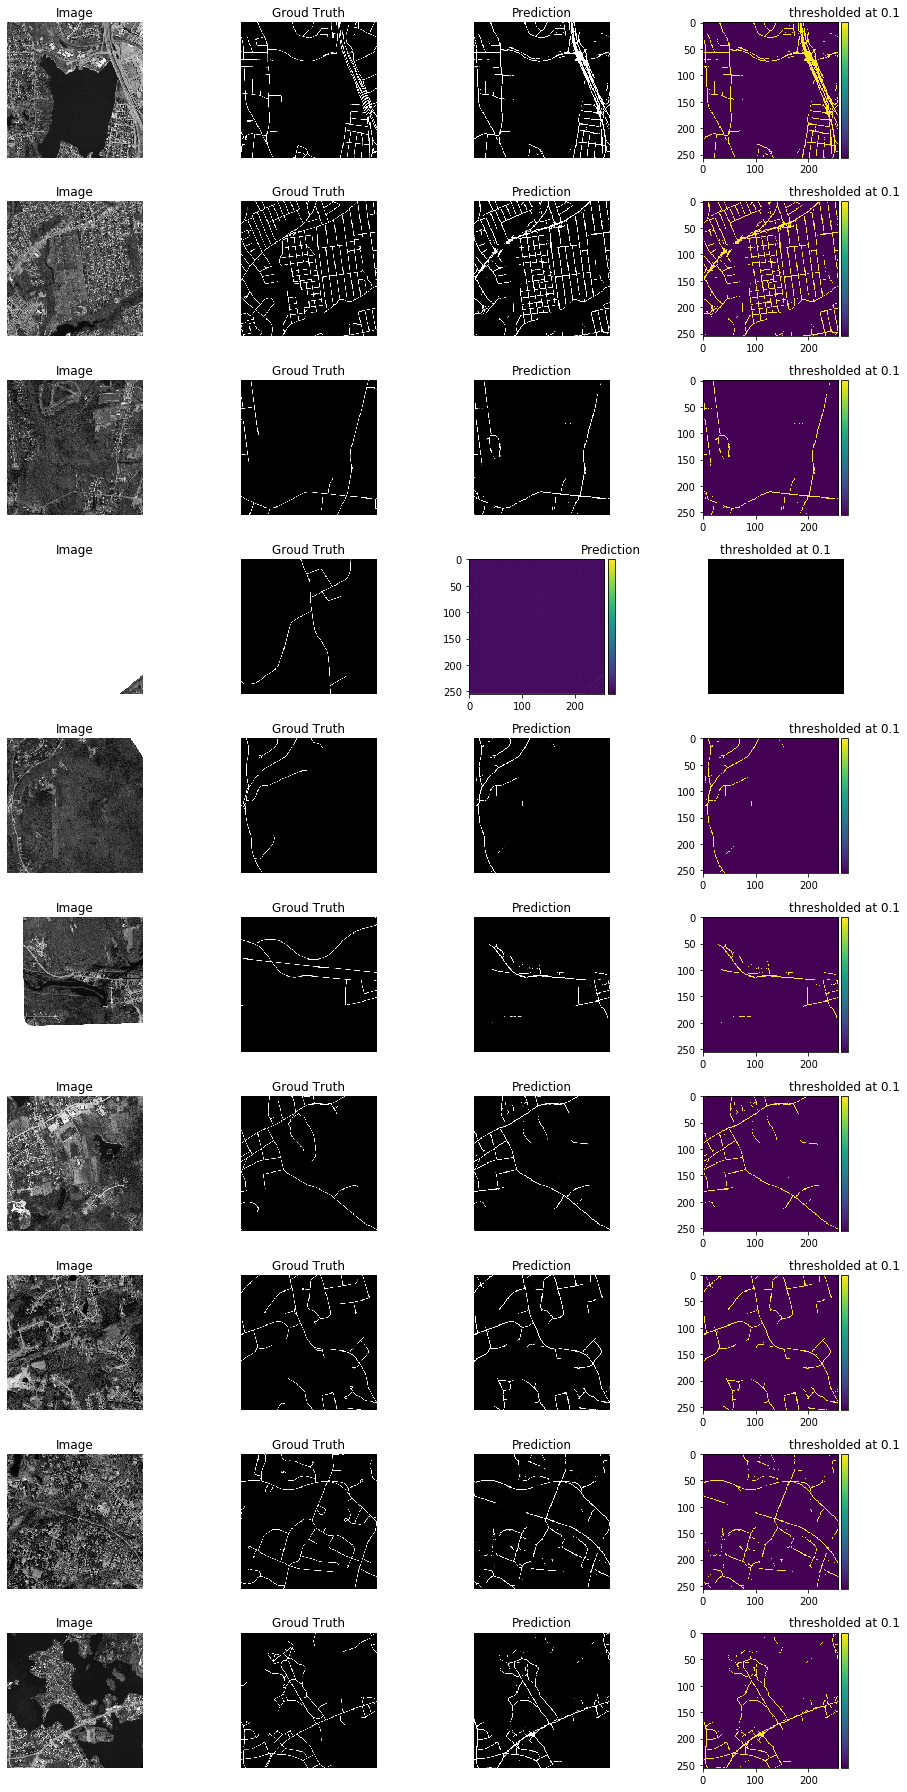

In [52]:
num_samples = 10
f = plt.figure(figsize=(15, 25))

for i in range(1, num_samples * 4, 4):
    ix = random.randint(0, len(predictions))

    f.add_subplot(num_samples, 4, i)
    imshow(test_images[ix][:, :, 0])
    plt.title("Image")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i + 1)
    imshow(np.squeeze(test_masks[ix][:, :, 0]))
    plt.title("Ground Truth")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i + 2)
    imshow(np.squeeze(predictions[ix][:, :, 0]))
    plt.title("Prediction")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i + 3)
    imshow(np.squeeze(predicton_threshold[ix][:, :, 0]))
    plt.title("Thresholded at {}".format(0.1))
    plt.axis('off')

plt.show()

In [53]:
newimg = cv2.imread('/content/drive/My Drive/datasets/img1.tiff')
resized_newimg = cv2.resize(newimg, (256, 256))
print(resized_newimg.shape)

(256, 256, 3)


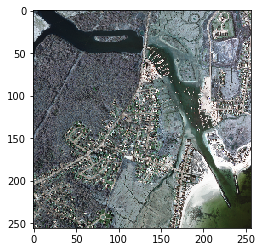

In [54]:
plt.imshow(resized_newimg)

In [55]:
listimg = list()
listimg.append(resized_newimg)
listimg = np.asarray(listimg)
predictions_new = model.predict(listimg, verbose=1)

1/1 [==============================] - 0s 21ms/step


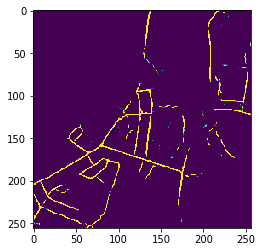

In [56]:
plt.imshow(np.squeeze(predictions_new[0]))
